<a href="https://colab.research.google.com/github/ge43jef/GEEHYDRO/blob/main/task2_working_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd
import numpy as np
from glob import glob

files = glob('FLX*') + glob('era*')


In [42]:
data = pd.concat((pd.read_csv(file)for file in files), ignore_index =True)
meteo = pd.DataFrame(
            {"sw": data.SW_IN_F, "lw": data.LW_IN_F,
            "pre": data.PA_F, "u10": data.WS_F,  "vpd": data.VPD_F , "lh": data.LE_CORR})
##meteo

In [54]:
from sklearn.model_selection import train_test_split
def normalization(x):
    x= (x-min(x)) / (max(x) - min(x))
    return x
# For files starting with 'FLX'
flx_data = []
for file_path in glob('FLX*'):
    df = pd.read_csv(file_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y%m%d')  # Convert TIMESTAMP column to datetime type
    flx_data.append(df[['TIMESTAMP', 'SW_IN_F', 'LW_IN_F', 'PA_F', 'WS_F', 'VPD_F', 'LE_CORR']][1:])  # Extract specific columns and exclude header

# Concatenate the FLX dataframes into a single dataframe
flx_combined = pd.concat(flx_data)

# For files starting with 'era'
era_data = []
for file_path in glob('era*'):
    df = pd.read_csv(file_path)
    df['date'] = df['system:index'].str.split('_').str[0]  # Extract date part from system:index
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')  # Convert date column to datetime type
    era_data.append(df[['date', 'temperature_2m', 'total_precipitation_sum']])  # Extract specific columns

# Concatenate the era dataframes into a single dataframe
era_combined = pd.concat(era_data)

# Merge the two dataframes based on the common columns (TIMESTAMP and date)
combined = pd.merge(flx_combined, era_combined, left_on='TIMESTAMP', right_on='date')

# Optionally, drop the extra columns (TIMESTAMP and date) if desired
combined = combined.drop(['TIMESTAMP', 'date'], axis=1)

data_all = np.array(combined)
for i in range(7):
    data_all[: , i] = normalization(data_all[:,i])


X = np.delete(data_all, np.where(combined.columns == 'LE_CORR'), axis=1)
y = data_all[:, np.where(combined.columns == 'LE_CORR')].flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print(y_test.shape)
print(y_train.shape)
print(y.shape)

(10365,)
(41459,)
(51824,)


In [44]:
from torch import nn
class MLP_regree(nn.Module):
    '''
      Multilayer Perceptron for classification.
    '''

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(7, 12),
            nn.ReLU(),
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 6),
            nn.ReLU(),
            nn.Linear(6, 1),

        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [45]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [46]:
class Dataset(torch.utils.data.Dataset):
    '''
    Prepare the dataset for neural network
    '''

    def __init__(self, X, y):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary

            self.X = torch.from_numpy(X).type(torch.float)
            self.y = torch.from_numpy(y).type(torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [47]:
import torch
from sklearn.model_selection import KFold


kfold = KFold(n_splits=5, shuffle=True)
if __name__ == '__main__':

    # Set fixed random number seed
    torch.manual_seed(4078)
    dataset = Dataset(X_train, y_train)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        trainloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=100, sampler=train_subsampler )
        testloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=100 , sampler=test_subsampler)
        mlp = MLP_regree()
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.0001)

    # Run the training loop
        for epoch in range(0, 100):

        # Print epoch
            print(f'Starting epoch {epoch + 1}')

        # Set current loss value
            current_loss = 0.0

        # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):
            # Get and prepare inputs
                inputs, targets = data
            #inputs, targets = inputs.float(), targets.float()
                targets = targets.reshape((targets.shape[0], 1))

            # Zero the gradients
                optimizer.zero_grad()
                outputs = mlp(inputs)
                loss = loss_function( outputs , targets )

            # Perform backward pass
                loss.backward()

            # Perform optimization
                optimizer.step()

            # Print statistics

                if i % 10 == 0:
                    print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, loss.item()))
                current_loss = 0.0

    # Process is complete.
    print('Training process has finished.')

Streaming output truncated to the last 5000 lines.
Loss after mini-batch    71: 0.000
Loss after mini-batch    81: 0.000
Loss after mini-batch    91: 0.000
Loss after mini-batch   101: 0.000
Loss after mini-batch   111: 0.000
Loss after mini-batch   121: 0.000
Loss after mini-batch   131: 0.000
Loss after mini-batch   141: 0.009
Loss after mini-batch   151: 0.000
Loss after mini-batch   161: 0.000
Loss after mini-batch   171: 0.000
Loss after mini-batch   181: 0.000
Loss after mini-batch   191: 0.000
Loss after mini-batch   201: 0.000
Loss after mini-batch   211: 0.000
Loss after mini-batch   221: 0.000
Loss after mini-batch   231: 0.018
Loss after mini-batch   241: 0.009
Loss after mini-batch   251: 0.000
Loss after mini-batch   261: 0.000
Loss after mini-batch   271: 0.000
Loss after mini-batch   281: 0.000
Loss after mini-batch   291: 0.009
Loss after mini-batch   301: 0.000
Loss after mini-batch   311: 0.009
Loss after mini-batch   321: 0.000
Loss after mini-batch   331: 0.009
Star

Starting epoch 1
Loss after mini-batch     1: 0.518
Loss after mini-batch     6: 0.518
Loss after mini-batch    11: 0.516
Loss after mini-batch    16: 0.517
Loss after mini-batch    21: 0.514
Loss after mini-batch    26: 0.512
Loss after mini-batch    31: 0.514
Loss after mini-batch    36: 0.513
Loss after mini-batch    41: 0.511
Loss after mini-batch    46: 0.511
Loss after mini-batch    51: 0.509
Loss after mini-batch    56: 0.510
Loss after mini-batch    61: 0.508
Loss after mini-batch    66: 0.507
Loss after mini-batch    71: 0.504
Loss after mini-batch    76: 0.506
Loss after mini-batch    81: 0.503
Starting epoch 2
Loss after mini-batch     1: 0.504
Loss after mini-batch     6: 0.498
Loss after mini-batch    11: 0.496
Loss after mini-batch    16: 0.493
Loss after mini-batch    21: 0.488
Loss after mini-batch    26: 0.485
Loss after mini-batch    31: 0.481
Loss after mini-batch    36: 0.476
Loss after mini-batch    41: 0.470
Loss after mini-batch    46: 0.467
Loss after mini-batch

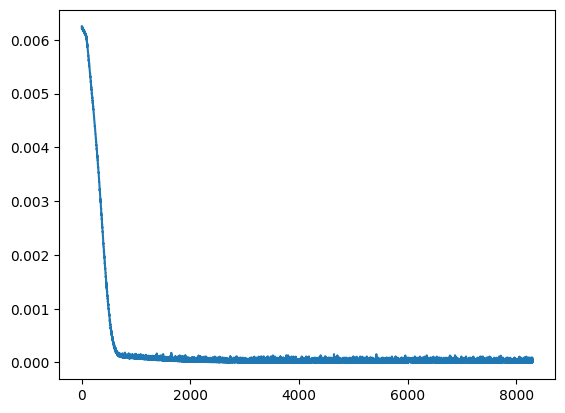

In [48]:
import matplotlib.pyplot as plt
if __name__ == '__main__':
    loss_values = []
    # Set fixed random number seed
    torch.manual_seed(4078)
    dataset = Dataset(X_train, y_train)
    trainloader = DataLoader(dataset, batch_size = 500 , shuffle=True)
    mlp = MLP_regree() # model with optimal hyperparameter combinations

    # Define the loss function and optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.0001)

    # Run the training loop
    for epoch in range(0, 100):

        # Print epoch
        print(f'Starting epoch {epoch + 1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):
            # Get and prepare inputs
            inputs, targets = data
            #inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))

            # Zero the gradients
            optimizer.zero_grad()
            outputs = mlp(inputs)
            loss = loss_function(outputs , targets )

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()
            current_loss += loss.item()

            # Print statistics
            loss_values.append(current_loss / len(trainloader))
            if i % 5 == 0:
                print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, loss.item()))
            current_loss = 0.0

    # Process is complete.
    print('Training process has finished.')
    plt.plot(loss_values)

In [70]:
# performance on test data
dataset = Dataset(X_test, y_test)
batch_size = len(X_test)  # Set the batch size equal to the length of X_test
testloader = DataLoader(dataset, batch_size=batch_size)

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
         # Get and prepare inputs
        inputs, targets = data
        output = mlp(inputs)


<Figure size 640x480 with 0 Axes>

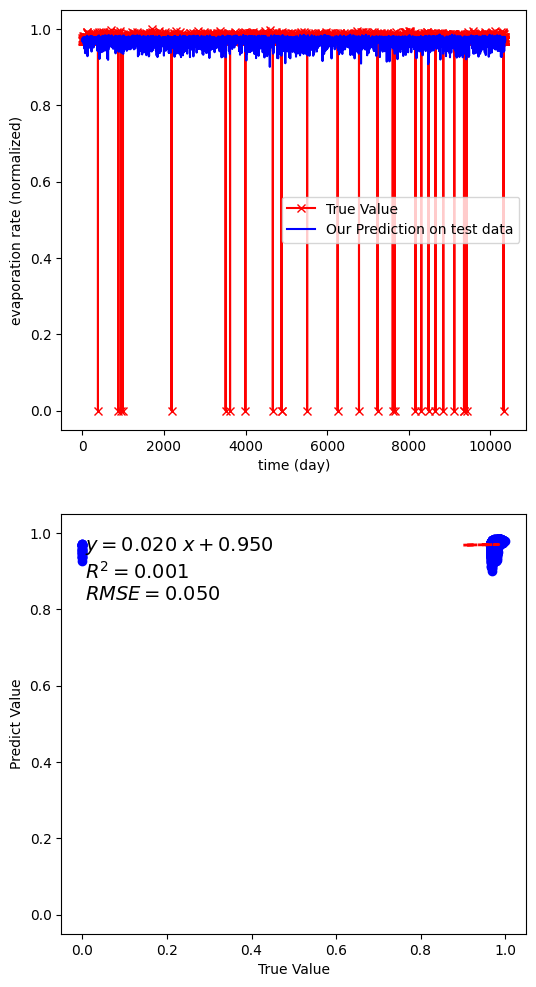

In [71]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Plot the data points
fig = plt.figure()
fig,ax=plt.subplots(2, 1, figsize=(6, 12), sharey=True)
ax[0].plot( y_test, marker='x', c='r',label='True Value')
ax[0].plot( output , c='b',label='Our Prediction on test data')
ax[0].set(xlabel="time (day)", ylabel="evaporation rate (normalized)")

ax[1].scatter( y_test , output.flatten() , c='b')
z = np.polyfit(y_test , output.flatten() , 1)
y_hat = np.poly1d(z)(output)
plt.plot(output.flatten(), y_hat, "r--", lw=2)
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y_test, y_hat):0.3f}$\n" \
                   f"$RMSE = {mean_squared_error(y_test, y_hat, squared=False):0.3f} $ "
plt.gca().text(0.05, 0.95, text, transform=plt.gca().transAxes,
                           fontsize=14, verticalalignment='top')
plt.ylabel('Predict Value')
# Set the x-axis label
plt.xlabel('True Value')
ax[0].legend()
plt.show()